# Letter Frequency in Wordle Solutions
## Which letters carry the most information when guessing?
I've found that I enjoy Wordle better when I change out my seed words, so I'm less interested now in finding the perfect starter. Instead I'm curious which letters (in which positions) provide the most useful information, by eliminating the most options. Armed with that knowledge, I can choose whichever seed word strikes my fancy, without being tied down to some canonical guess list.

This is also a good excuse to practice using Pandas.

In [1]:
# always gotta start with those imports
import numpy as np
import pandas as pd

First, load the valid guess and solution lists into Pandas DataFrames where each row includes the whole word and each of the letters of the word in columns. I'm using alphabatized lists extracted by [Bill Cruise](https://www.kaggle.com/bcruise), available [on Kaggle](https://www.kaggle.com/bcruise/wordle-valid-words). These lists don't reflect the NY Times word lists. I'm randomizing the output, to avoid always having to look at "a" words when printing out the data frames. To match the Wordle UI and a common convention among players, I also convert the letters to uppercase.

In [2]:
def load_words(in_path):
    words = pd.read_csv(in_path)
    letters = words["word"].str.upper().str.split('', expand=True).drop(columns=[0, 6])
    return words.join(letters).sample(frac=1, random_state=15).reset_index()


guesses = load_words('valid_guesses.csv')
solutions = load_words('valid_solutions.csv')

Here's what this looks like (first 25 solutions):

In [3]:
solutions.head(25)

,index,word,1,2,3,4,5
0,164,bayou,B,A,Y,O,U
1,2257,whirl,W,H,I,R,L
2,440,coral,C,O,R,A,L
3,1844,sound,S,O,U,N,D
4,283,broil,B,R,O,I,L
5,1964,sulky,S,U,L,K,Y
6,923,grove,G,R,O,V,E
7,1007,hurry,H,U,R,R,Y
8,1067,junto,J,U,N,T,O
9,1124,lemur,L,E,M,U,R


### Baseline Letter Frequencies
Here I'm using only the positional columns and applying the `value_counts` function to get the total count for each letter. The calls to `convert_dtypes()` are there to coerce the counts to integers for non-normalized result and floats for normalized results. The `value_counts` function treats missing values (e.g. "j" in position 5) as `NaN` so `fillna(0)` is called to set those results to `0`. 

Normalized results are good for comparing the results between the valid guesses and valid solutions.

In [4]:
def get_frequency(df, normalize=False):
    fill = 0.0 if normalize else 0
    return df.drop(columns=["index","word"]).apply(lambda x: x.value_counts(normalize=normalize)).fillna(fill).convert_dtypes()

guess_freq = get_frequency(guesses, normalize=True)
solution_freq = get_frequency(solutions, normalize=True)

Taking a look at the results (for the solutions):

In [5]:
solution_freq

,1,2,3,4,5
A,0.060907,0.131317,0.132613,0.07041,0.027646
B,0.07473,0.006911,0.024622,0.010367,0.004752
C,0.085529,0.017279,0.02419,0.065659,0.013391
D,0.047948,0.008639,0.032397,0.029806,0.050972
E,0.031102,0.104536,0.076458,0.137365,0.183153
F,0.058747,0.003456,0.010799,0.015119,0.011231
G,0.049676,0.005184,0.028942,0.032829,0.017711
H,0.029806,0.062203,0.003888,0.012095,0.060043
I,0.014687,0.087257,0.114903,0.068251,0.004752
J,0.008639,0.000864,0.001296,0.000864,0.0


### Plot It

Heatmaps are a great way to visualize what's happening in this data. 

Here I'm using excellent colormaps provided by [Fabio Crameri](https://www.fabiocrameri.ch/colourmaps/). I chose the a divergent palette to highlight middle values as well as those at the extremes.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
sns.set_theme()

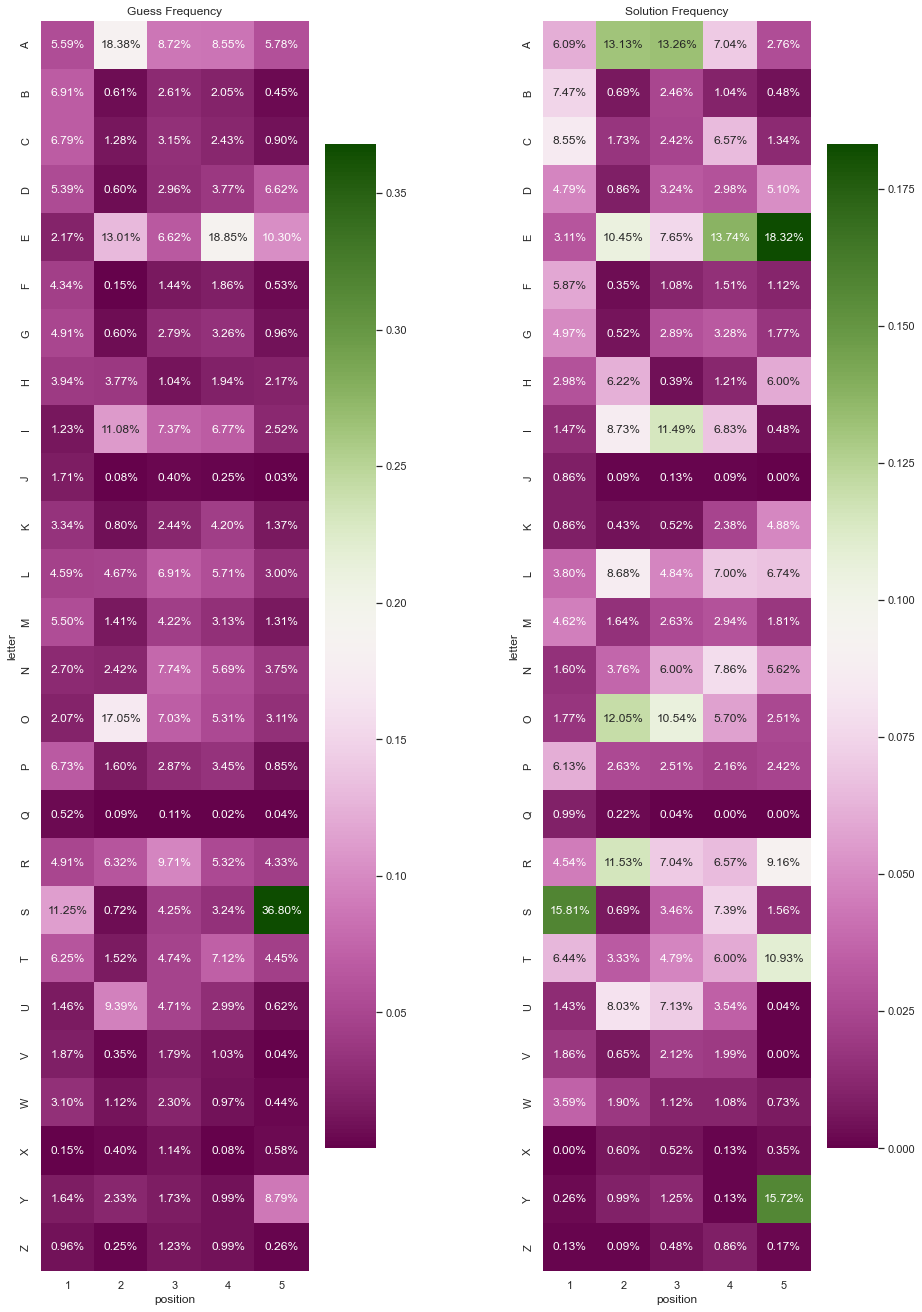

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 23))
fig.subplots_adjust(wspace=0.5)
hm1 = sns.heatmap(
    guess_freq.astype(float),
    ax=axes[0], cmap=cm.bam,
    annot=True, fmt='.2%'
).set(
    title='Guess Frequency',
    xlabel='position',
    ylabel='letter'
)
hm2 = sns.heatmap(
    solution_freq.astype(float),
    ax=axes[1], cmap=cm.bam,
    annot=True, fmt='.2%'
).set(
    title='Solution Frequency',
    xlabel='position',
    ylabel='letter'
)

Hotter values (in green) indicate a higher frequency of that combination of letter and position, and the more likely a guess with that comination is likely to be a "hit" (green block). However, a hit also eliminates fewer combinations -- in the absence of a success or other clues, these hits provide the least amount of information. Cooler combos (dark magenta) are the inverse. The takeaway here is that any choice has to balance the value of a possible hit against the risk of less useful information.

A glance at these heatmaps shows that the guess list is much more homogenous that the solution list. There are a few interesting outliers in the solutions: an `E` or `Y` in position `5` is very hot, while `J` and `Z` are very, very cool in all positions. Maybe the most interesting are those in the middle: `C` in position `1`, `I` and `L` in position `2`, `R` in position `5`, etc. I wonder if those cominations provide the best balance of risk and reward?

What about just the vowels? How do guesses like `ADIEU` and `PIOUS` stack up?

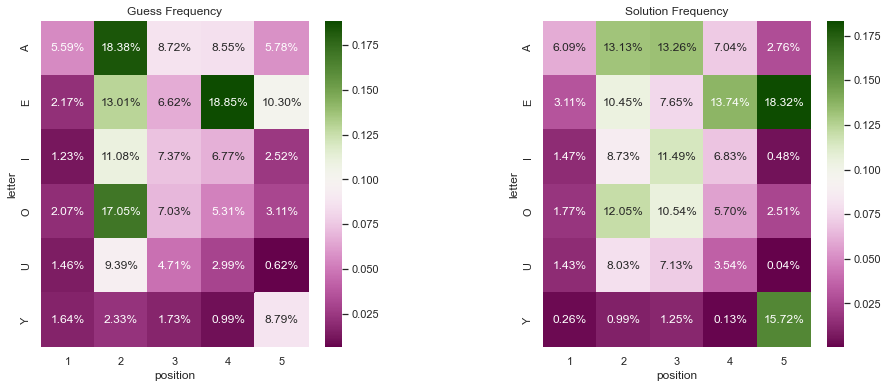

In [12]:
guess_vowels = guess_freq.loc[['A','E','I','O','U','Y']]
solution_vowels = solution_freq.loc[['A','E','I','O','U','Y']]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.5)
hm1 = sns.heatmap(
    guess_vowels.astype(float),
    ax=axes[0], cmap=cm.bam,
    annot=True, fmt='.2%'
).set(
    title='Guess Frequency',
    xlabel='position',
    ylabel='letter'
)
hm2 = sns.heatmap(
    solution_vowels.astype(float),
    ax=axes[1], cmap=cm.bam,
    annot=True, fmt='.2%'
).set(
    title='Solution Frequency',
    xlabel='position',
    ylabel='letter'
)

The difference between the guess list and the solution list is even more stark here. Almost a fifth of all the solution words end in `E`, nearly double the frequency of the guess list.